In [7]:
import sunpy

import datetime
from datetime import datetime
from datetime import timedelta

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.units as u
from astropy.io import fits
from astropy.vo.samp import SAMPIntegratedClient

from sunpy.net import vso

In [8]:
client = SAMPIntegratedClient()
client.connect()

In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

class VSOHandler(object):
    def __init__(self, timestamp, instrument, wave):
        self.timestamp = timestamp
        self.instrument = instrument
        self.wave = wave
        
        self.client = vso.VSOClient()
        
    def createQuery(self, delta=timedelta(minutes = 2)):
        askedTime = datetime.strptime(self.timestamp,'%Y/%m/%dT%H:%M:%S.%f')
        
        self.query = self.client.query(
            vso.attrs.Time(askedTime - delta , askedTime + delta),
            vso.attrs.Instrument('AIA'),
            vso.attrs.Wave(self.wave * u.AA, self.wave * u.AA))
        return self.query
    
    def checkResult(self):
        print(self.query)
    
    def showData(self):
        files = self.client.get(self.query, path='/Data/{instrument}/{file}.fits').wait()
        hdu_list = fits.open(files[0])
        hdu_list.info()
        image_data = hdu_list[0].data
        hdu_list.close()
        plt.imshow(image_data)
        plt.colorbar()

class Receiver(object):
    def __init__(self, client):
        self.client = client
        self.received = False
    def receive_call(self, private_key, sender_id, msg_id, mtype, params, extra):
        self.params = params
        self.received = True
        self.client.reply(msg_id, {"samp.status": "samp.ok", "samp.result": {}})
    def receive_notification(self, private_key, sender_id, mtype, params, extra):
        self.params = params
        self.received = True
    
    def createHandler(self):
        if r.received:
            timestamp = r.params['timestamp']
            wave = int(r.params['wave'])
            instrument = r.params['instrument']
            r.received = False 
            
            handler = VSOHandler(timestamp, instrument, wave)
            handler.createQuery()

            
            return handler

In [14]:
r = Receiver(client)
client.bind_receive_call("jhv.vso.load", r.receive_call)
client.bind_receive_notification("jhv.vso.load", r.receive_notification)

In [15]:
r.received

False

In [16]:
# We test every 0.1s to see if the hub has sent a message
import time
while True:
    time.sleep(0.1)
    if r.received:
        handler = r.createHandler()
        break

In [18]:
handler.createQuery(timedelta(seconds=2))

Start Time [1],End Time [1],Source,Instrument,Type
str19,str19,str3,str3,str8
2015-09-01 15:41:58,2015-09-01 15:41:59,SDO,AIA,FULLDISK


In [19]:
handler.checkResult()

   Start Time [1]       End Time [1]    Source Instrument   Type  
------------------- ------------------- ------ ---------- --------
2015-09-01 15:41:58 2015-09-01 15:41:59    SDO        AIA FULLDISK


Filename: /Data/AIA/aia_lev1_171a_2015_09_01t15_41_58_34z_image_lev1.fits.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       6   ()      
  1              CompImageHDU    187   (4096, 4096)   int16   


TypeError: Image data can not convert to float

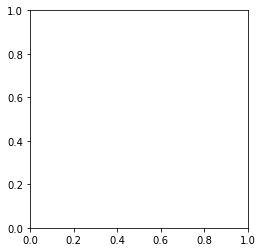

In [20]:
handler.showData()

In [25]:
client = vso.VSOClient()
qr = client.query(
    vso.attrs.Time('2017/04/01T14:29:55.350', '2017/04/01T14:30:02.350'),
    vso.attrs.Instrument('AIA'),
    vso.attrs.Wave(171 * u.AA, 171 * u.AA))
print(qr)

   Start Time [1]       End Time [1]    Source Instrument   Type  
------------------- ------------------- ------ ---------- --------
2017-04-01 14:29:57 2017-04-01 14:29:58    SDO        AIA FULLDISK


In [27]:
files = client.get(qr, path='/Data/{instrument}/{file}.fits').wait()
hdu_list = fits.open(files[0])
hdu_list.info()

Filename: /Data/AIA\aia_lev1_171a_2017_04_01t14_29_57_35z_image_lev1.fits.1.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       6   ()      
  1              CompImageHDU    187   (4096, 4096)   int16   


In [30]:
hdu_list[1].verify('fix')
image_data = hdu_list[1].data

 [astropy.io.fits.verify]


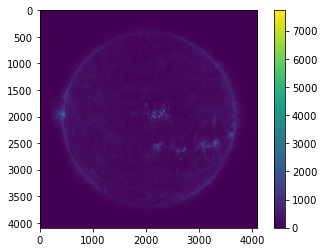

In [31]:
hdu_list.close()
plt.imshow(image_data)
plt.colorbar()